# MCMC-Based Machine Unlearning (MCU)
### Replication of: *"Markov Chain Monte Carlo-Based Machine Unlearning: Unlearning what needs to be forgotten"* — ASIACCS 2022

---

**Machine Unlearning** is the problem of removing the influence of specific training points from a trained model *without retraining from scratch*.

### Why does it matter?
| Motivation | Example |
|---|---|
| 🔒 Right to be Forgotten (GDPR/CCPA) | A user requests their data be deleted |
| ☣️ Poisoning attack mitigation | Remove adversarially injected samples |
| ✏️ Data correction | Fix mislabeled / corrupted training data |

### MCU Core Idea
Instead of full retraining, MCU uses **Bayesian Importance Sampling** to reweight the existing posterior:

$$P(\theta \mid D_r) \propto \frac{P(\theta \mid D)}{P(D_e \mid \theta)}$$

This notebook walks through every step: dataset setup → MCMC training → unlearning → evaluation & diagnostics.

## Section 1 — Setup & Imports

Install and import all required libraries. JAX provides GPU-accelerated numerical computing; NumPyro is the probabilistic programming framework built on JAX; scikit-learn handles dataset generation and metrics.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Reproducibility
np.random.seed(42)

print(f"JAX version  : {jax.__version__}")
print(f"NumPyro ver  : {numpyro.__version__}")
print(f"JAX backend  : {jax.default_backend()}")

JAX version  : 0.9.0.1
NumPyro ver  : 0.20.0
JAX backend  : cpu


## Section 2 — Dataset Generation

We generate a synthetic tabular binary classification dataset designed to mimic the [UCI Phishing Websites Dataset](https://archive.ics.uci.edu/ml/datasets/phishing+websites).

| Property | Value |
|---|---|
| Total samples | 1000 |
| Features | 15 (10 informative, 2 redundant, 3 noise) |
| Class separation | 1.2 |
| Train / Test split | 80% / 20% |
| Task | Binary classification: `0` = legitimate, `1` = phishing |

`make_classification` creates correlated, realistic feature structures — not a trivially separable dataset.

Training samples : 800
Test samples     : 200
Features         : 15
Class balance    : train [410 390], test [ 92 108]


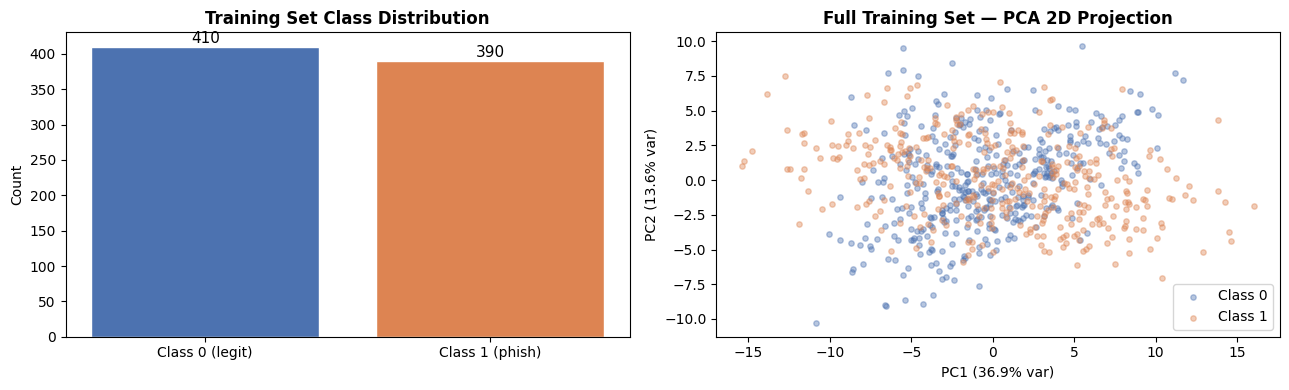

In [3]:
def generate_dataset(n_samples=1000, n_features=15, random_state=42):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=10,
        n_redundant=2,
        class_sep=1.2,
        random_state=random_state
    )
    return train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_test, y_train, y_test = generate_dataset()
D_test = (X_test, y_test)

print(f"Training samples : {X_train.shape[0]}")
print(f"Test samples     : {X_test.shape[0]}")
print(f"Features         : {X_train.shape[1]}")
print(f"Class balance    : train {np.bincount(y_train)}, test {np.bincount(y_test)}")

# --- Visualization: Class distribution + PCA overview ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Class bar chart
axes[0].bar(["Class 0 (legit)", "Class 1 (phish)"], np.bincount(y_train),
            color=["#4C72B0", "#DD8452"], edgecolor="white")
axes[0].set_title("Training Set Class Distribution", fontweight="bold")
axes[0].set_ylabel("Count")
for i, v in enumerate(np.bincount(y_train)):
    axes[0].text(i, v + 5, str(v), ha="center", fontsize=11)

# PCA 2D scatter of all training data
pca_vis = PCA(n_components=2)
X_2d_vis = pca_vis.fit_transform(X_train)
var_vis = pca_vis.explained_variance_ratio_
for cls, color, label in [(0, "#4C72B0", "Class 0"), (1, "#DD8452", "Class 1")]:
    mask = y_train == cls
    axes[1].scatter(X_2d_vis[mask, 0], X_2d_vis[mask, 1],
                    c=color, alpha=0.4, s=15, label=label)
axes[1].set_title("Full Training Set — PCA 2D Projection", fontweight="bold")
axes[1].set_xlabel(f"PC1 ({var_vis[0]*100:.1f}% var)")
axes[1].set_ylabel(f"PC2 ({var_vis[1]*100:.1f}% var)")
axes[1].legend()
plt.tight_layout()
plt.show()

## Section 3 — Erase Set Configuration

The training data is split into two disjoint sets:

| Symbol | Name | Description |
|---|---|---|
| $D_r$ | **Retain set** | Data the model should keep knowing |
| $D_e$ | **Erase set** | Data whose influence must be removed |

### Two Deletion Modes

**`random`** — Remove 5 uniformly random training points.  
Simulates a single user data deletion request. Small, scattered erase set → easy for importance sampling.

**`cluster`** — Remove all points where `feature_0 > 90th percentile` (~80 points, ~10% of data).  
Simulates removing a structured demographic group or a poisoning cluster. Large, geometrically concentrated erase set → harder for importance sampling (risk of weight degeneracy).

> **Toggle `active_mode` below to switch between the two scenarios.**

Mode          : CLUSTER
Retain set D_r: 720 samples
Erase  set D_e: 80 samples  (10.0% of training data)


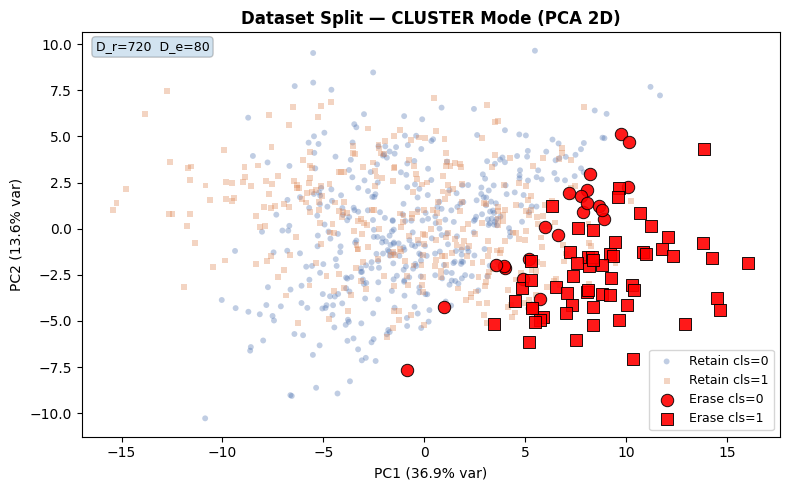

In [ ]:
def split_erase_data(X_train, y_train, mode="random", seed=42):
    np.random.seed(seed)
    n_train = len(X_train)
    if mode == "random":
        erase_indices = np.random.choice(n_train, 5, replace=False)
    elif mode == "cluster":
        threshold = np.percentile(X_train[:, 0], 90)
        erase_indices = np.where(X_train[:, 0] > threshold)[0]
    else:
        raise ValueError("Unknown mode.")
    erase_mask = np.zeros(n_train, dtype=bool)
    erase_mask[erase_indices] = True
    D_e = (X_train[erase_mask],  y_train[erase_mask])
    D_r = (X_train[~erase_mask], y_train[~erase_mask])
    return D_e, D_r

# ============================================================
#  TOGGLE HERE:  "random"  or  "cluster"
active_mode = "random"
# ============================================================

D_e, D_r = split_erase_data(X_train, y_train, mode=active_mode)
X_r, y_r = D_r
X_e, y_e = D_e

print(f"Mode          : {active_mode.upper()}")
print(f"Retain set D_r: {len(X_r)} samples")
print(f"Erase  set D_e: {len(X_e)} samples  ({len(X_e)/len(X_train)*100:.1f}% of training data)")

# --- PCA scatter: Retain vs Erase ---
fig, ax = plt.subplots(figsize=(8, 5))
X_all_combined = np.vstack([X_r, X_e])
y_all_combined = np.concatenate([y_r, y_e])
labels_combined = np.array(["Retain"] * len(X_r) + ["Erase"] * len(X_e))

pca_split = PCA(n_components=2)
X_2d_split = pca_split.fit_transform(X_all_combined)
var_split = pca_split.explained_variance_ratio_

style_map = {(0, "Retain"): ("o", "#4C72B0", 0.35, 18),
             (1, "Retain"): ("s", "#DD8452", 0.35, 18),
             (0, "Erase"):  ("o", "red",     0.90, 80),
             (1, "Erase"):  ("s", "red",     0.90, 80)}

for (cls, grp), (mrk, col, alp, sz) in style_map.items():
    mask = (y_all_combined == cls) & (labels_combined == grp)
    if mask.any():
        ax.scatter(X_2d_split[mask, 0], X_2d_split[mask, 1],
                   marker=mrk, c=col, alpha=alp, s=sz,
                   edgecolors="black" if grp == "Erase" else "none",
                   linewidths=0.7,
                   label=f"{grp} cls={cls}")

ax.set_title(f"Dataset Split — {active_mode.upper()} Mode (PCA 2D)", fontweight="bold")
ax.set_xlabel(f"PC1 ({var_split[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({var_split[1]*100:.1f}% var)")
ax.legend(fontsize=9)
ax.text(0.02, 0.98, f"D_r={len(X_r)}  D_e={len(X_e)}",
        transform=ax.transAxes, va="top", fontsize=9,
        bbox=dict(boxstyle="round", alpha=0.2))
plt.tight_layout()
plt.show()

## Section 4 — Bayesian Logistic Regression Model

### Model Definition

We place independent **standard Normal priors** on all parameters:

$$P(w) = \prod_{j=1}^{15} \mathcal{N}(w_j;\, 0,\, 1), \qquad P(b) = \mathcal{N}(b;\, 0,\, 1)$$

The **likelihood** for each training point uses the Bernoulli distribution with sigmoid-activated logits:

$$P(y_i = 1 \mid x_i,\, w,\, b) = \sigma(w^\top x_i + b), \qquad \sigma(z) = \frac{1}{1 + e^{-z}}$$

The joint **posterior** over the full training dataset $D$:

$$P(\theta \mid D) \propto \underbrace{P(D \mid \theta)}_{\text{likelihood}} \cdot \underbrace{P(\theta)}_{\text{prior}} = \prod_{i=1}^{n} \text{Bernoulli}(y_i \mid \sigma(\theta^\top x_i)) \cdot P(\theta)$$

NUTS (No-U-Turn Sampler) draws samples from this posterior using Hamiltonian Monte Carlo with automatic step-size tuning.

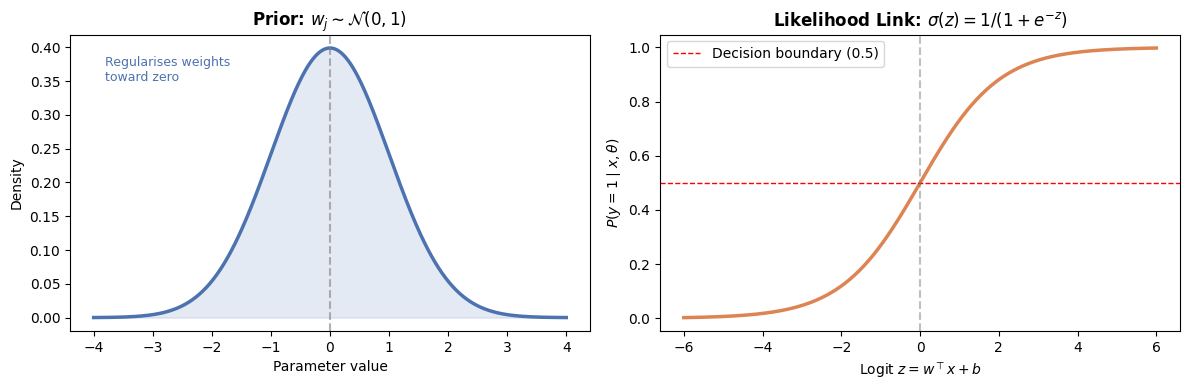

Model defined. Ready for MCMC training.


In [12]:
def bayesian_logistic_regression(X, y=None):
    """NumPyro Bayesian Logistic Regression model."""
    n_samples, n_features = X.shape
    w = numpyro.sample("w", dist.Normal(jnp.zeros(n_features), jnp.ones(n_features)))
    b = numpyro.sample("b", dist.Normal(0.0, 1.0))
    logits = jnp.matmul(X, w) + b
    with numpyro.plate("data", n_samples):
        numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

def train_mcmc(X, y, num_warmup=500, num_samples=1000, rng_key=random.PRNGKey(0)):
    """Runs NUTS MCMC and returns posterior samples."""
    kernel = NUTS(bayesian_logistic_regression)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, progress_bar=True)
    mcmc.run(rng_key, X=jnp.array(X, dtype=jnp.float32),
                      y=jnp.array(y, dtype=jnp.float32))
    return mcmc.get_samples()

# --- Visualize the Standard Normal prior ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

z = np.linspace(-4, 4, 400)
prior_pdf = scipy.stats.norm.pdf(z, 0, 1)

axes[0].plot(z, prior_pdf, color="#4C72B0", linewidth=2.5)
axes[0].fill_between(z, prior_pdf, alpha=0.15, color="#4C72B0")
axes[0].axvline(0, color="grey", linestyle="--", alpha=0.6)
axes[0].set_title("Prior: $w_j \\sim \\mathcal{N}(0, 1)$", fontweight="bold")
axes[0].set_xlabel("Parameter value")
axes[0].set_ylabel("Density")
axes[0].text(-3.8, 0.35, "Regularises weights\ntoward zero", fontsize=9, color="#4C72B0")

# Sigmoid function
z_sig = np.linspace(-6, 6, 400)
axes[1].plot(z_sig, 1/(1+np.exp(-z_sig)), color="#DD8452", linewidth=2.5)
axes[1].axhline(0.5, color="red", linestyle="--", linewidth=1, label="Decision boundary (0.5)")
axes[1].axvline(0, color="grey", linestyle="--", alpha=0.5)
axes[1].set_title("Likelihood Link: $\\sigma(z) = 1/(1+e^{-z})$", fontweight="bold")
axes[1].set_xlabel("Logit $z = w^\\top x + b$")
axes[1].set_ylabel("$P(y=1 \\mid x, \\theta)$")
axes[1].legend()

plt.tight_layout()
plt.show()
print("Model defined. Ready for MCMC training.")

## Section 5 — MCMC Training: Base Model on Full Dataset $D$

We train the base model on the **full dataset** $D = D_r \cup D_e$ using the NUTS sampler.

### NUTS Configuration
| Parameter | Value | Purpose |
|---|---|---|
| `num_warmup` | 500 | Tuning phase — step size & mass matrix adaptation (discarded) |
| `num_samples` | 1500 | Retained posterior samples used for inference |
| `rng_key` | PRNGKey(1) | Deterministic seeding |

### What is NUTS?
NUTS (No-U-Turn Sampler) extends HMC by automatically choosing trajectory lengths. It simulates Hamiltonian dynamics in the parameter space using the **gradient of the log-posterior** to make efficient, large, directed steps across the posterior — far more efficient than random-walk Metropolis.

The MCMC trace below should show **good mixing** — a stationary, rapidly oscillating chain with no obvious trends or stuck regions.

Training Base Model on full dataset D = D_r ∪ D_e ...


sample: 100%|██████████| 2000/2000 [00:06<00:00, 327.96it/s, 255 steps of size 3.49e-02. acc. prob=0.95]



Posterior sample shapes:
  w : (1500, 15)   (num_samples × n_features)
  b : (1500,)   (num_samples,)


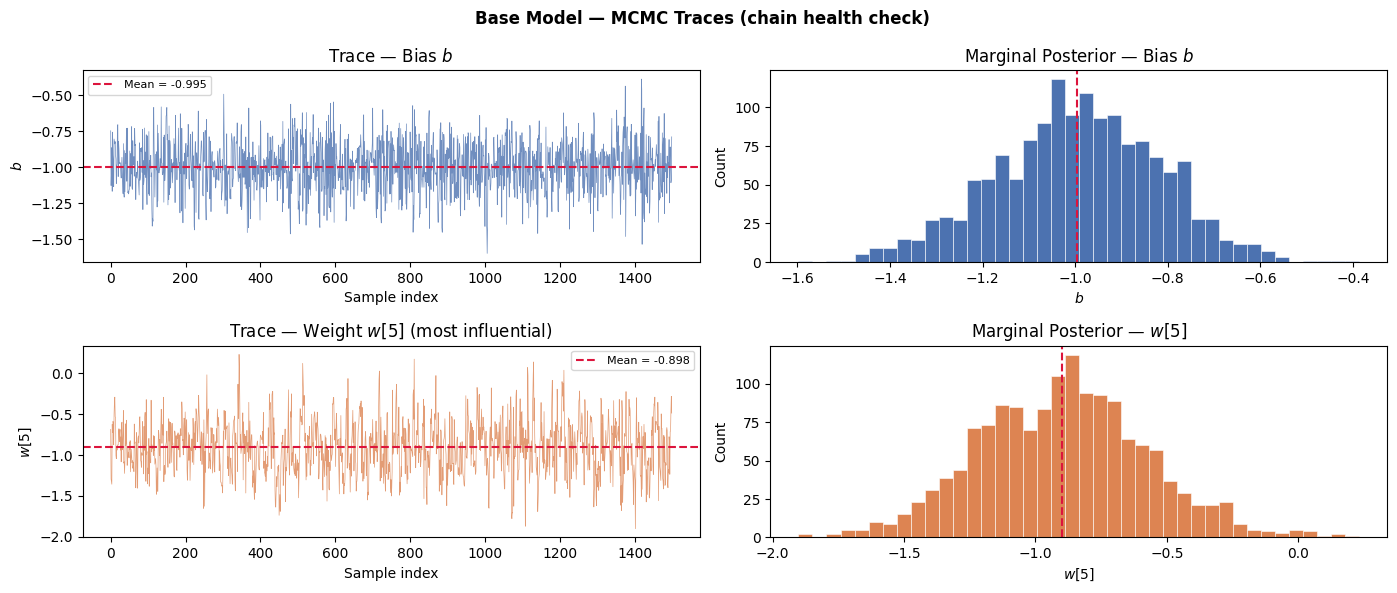

In [13]:
print("Training Base Model on full dataset D = D_r ∪ D_e ...")
X_full = np.vstack((X_r, X_e))
y_full = np.concatenate((y_r, y_e))

base_samples = train_mcmc(X_full, y_full, num_warmup=500, num_samples=1500,
                           rng_key=random.PRNGKey(1))

print(f"\nPosterior sample shapes:")
print(f"  w : {base_samples['w'].shape}   (num_samples × n_features)")
print(f"  b : {base_samples['b'].shape}   (num_samples,)")

# --- MCMC Trace plots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
fig.suptitle("Base Model — MCMC Traces (chain health check)", fontweight="bold")

b_base = np.array(base_samples["b"])
w_base = np.array(base_samples["w"])

# Top row: bias b trace + histogram
axes[0, 0].plot(b_base, color="#4C72B0", linewidth=0.5, alpha=0.8)
axes[0, 0].axhline(b_base.mean(), color="crimson", linestyle="--", linewidth=1.5,
                   label=f"Mean = {b_base.mean():.3f}")
axes[0, 0].set_title("Trace — Bias $b$")
axes[0, 0].set_xlabel("Sample index")
axes[0, 0].set_ylabel("$b$")
axes[0, 0].legend(fontsize=8)

axes[0, 1].hist(b_base, bins=40, color="#4C72B0", edgecolor="white", linewidth=0.4)
axes[0, 1].axvline(b_base.mean(), color="crimson", linestyle="--", linewidth=1.5)
axes[0, 1].set_title("Marginal Posterior — Bias $b$")
axes[0, 1].set_xlabel("$b$")
axes[0, 1].set_ylabel("Count")

# Bottom row: w[0] trace + histogram
top_dim = int(np.argmax(np.abs(w_base.mean(axis=0))))
axes[1, 0].plot(w_base[:, top_dim], color="#DD8452", linewidth=0.5, alpha=0.8)
axes[1, 0].axhline(w_base[:, top_dim].mean(), color="crimson", linestyle="--",
                   linewidth=1.5, label=f"Mean = {w_base[:, top_dim].mean():.3f}")
axes[1, 0].set_title(f"Trace — Weight $w[{top_dim}]$ (most influential)")
axes[1, 0].set_xlabel("Sample index")
axes[1, 0].set_ylabel(f"$w[{top_dim}]$")
axes[1, 0].legend(fontsize=8)

axes[1, 1].hist(w_base[:, top_dim], bins=40, color="#DD8452", edgecolor="white", linewidth=0.4)
axes[1, 1].axvline(w_base[:, top_dim].mean(), color="crimson", linestyle="--", linewidth=1.5)
axes[1, 1].set_title(f"Marginal Posterior — $w[{top_dim}]$")
axes[1, 1].set_xlabel(f"$w[{top_dim}]$")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Section 6 — MCU Unlearning via Importance Sampling

### The Core Mathematical Insight

Using Bayes' rule, the target retrained posterior can be expressed as:

$$P(\theta \mid D_r) = \frac{P(\theta \mid D)}{P(D_e \mid \theta)} \cdot Z^{-1}$$

This means we can **reweight** the existing MCMC samples from $P(\theta \mid D)$ rather than resampling from scratch.

### Importance Weight Formula

For each posterior sample $\theta_i$:

$$\log w_i = -\log P(D_e \mid \theta_i) = -\sum_{(x, y) \in D_e} \log \text{Bernoulli}\!\left(y \;\middle|\; \sigma(\theta_i^\top x)\right)$$

Normalized (via log-sum-exp to prevent numerical overflow):

$$\tilde{w}_i = \text{softmax}(\log w)_i = \frac{e^{\log w_i}}{\sum_j e^{\log w_j}}$$

### Effective Sample Size (ESS)

$$\text{ESS} = \frac{1}{\sum_{i=1}^N \tilde{w}_i^2}$$

- **ESS ≈ N**: Weights are uniform → the unlearning barely changed the posterior (small D_e)
- **ESS ≪ N**: Weight degeneracy → only a few samples dominate → unlearning quality degrades

### Intuition for weights
| Sample $\theta_i$ | Likelihood $P(D_e|\theta_i)$ | Weight $\tilde{w}_i$ | Meaning |
|---|---|---|---|
| Fits D_e poorly | Low | **High** | This sample is consistent with never having seen D_e |
| Fits D_e well | High | **Low** | This sample "remembers" D_e — de-emphasize it |

Applying MCU Importance Sampling...
  N samples             : 1500
  ESS                   : 5.4  (0.4% of N)
  Max weight            : 0.409035
  Uniform weight (1/N)  : 0.000667
  ⚠ WARNING: ESS < 10% — weight degeneracy detected!
    Consider using the Enlarged Candidate Set approach.


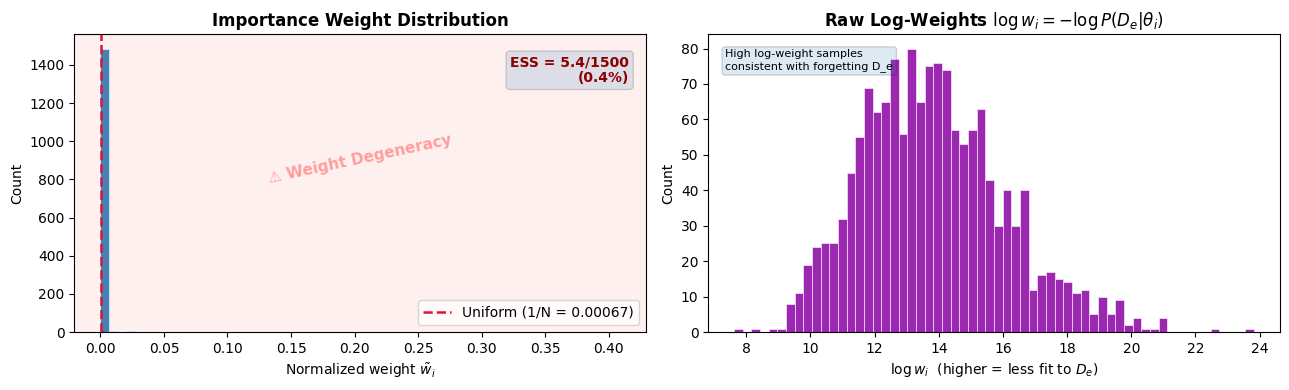

In [14]:
def perform_unlearning(D_e, posterior_samples):
    """
    MCU: compute normalized importance weights w̃_i = 1/P(D_e|θ_i).
    Returns a (num_samples,) array of normalized weights.
    """
    X_e, y_e = D_e
    w = posterior_samples['w']   # (N, d)
    b = posterior_samples['b']   # (N,)

    logits = jnp.dot(w, X_e.T) + b[:, None]        # (N, |D_e|)
    log_liks = dist.Bernoulli(logits=logits).log_prob(y_e)  # (N, |D_e|)
    total_log_lik = jnp.sum(log_liks, axis=1)       # (N,)

    log_weights = -total_log_lik                     # negate to get 1/P
    log_weights_norm = log_weights - jax.nn.logsumexp(log_weights)
    return jnp.exp(log_weights_norm)

print("Applying MCU Importance Sampling...")
unlearning_weights = perform_unlearning(D_e, base_samples)
weights_np = np.array(unlearning_weights)

N = len(weights_np)
ess = 1.0 / np.sum(weights_np ** 2)
ess_pct = ess / N * 100
print(f"  N samples             : {N}")
print(f"  ESS                   : {ess:.1f}  ({ess_pct:.1f}% of N)")
print(f"  Max weight            : {weights_np.max():.6f}")
print(f"  Uniform weight (1/N)  : {1/N:.6f}")
if ess_pct < 10:
    print("  ⚠ WARNING: ESS < 10% — weight degeneracy detected!")
    print("    Consider using the Enlarged Candidate Set approach.")

# --- Importance weight histogram ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(weights_np, bins=60, color="steelblue", edgecolor="white", linewidth=0.4)
axes[0].axvline(1.0/N, color="crimson", linestyle="--", linewidth=1.8,
                label=f"Uniform (1/N = {1/N:.5f})")
axes[0].set_title("Importance Weight Distribution", fontweight="bold")
axes[0].set_xlabel("Normalized weight $\\tilde{w}_i$")
axes[0].set_ylabel("Count")
axes[0].legend()
axes[0].text(0.97, 0.93, f"ESS = {ess:.1f}/{N}\n({ess_pct:.1f}%)",
             transform=axes[0].transAxes, ha="right", va="top",
             color="darkred", fontweight="bold", fontsize=10,
             bbox=dict(boxstyle="round", alpha=0.15))
if ess_pct < 10:
    axes[0].set_facecolor("#fff0f0")
    axes[0].text(0.5, 0.5, "⚠ Weight Degeneracy",
                 transform=axes[0].transAxes, fontsize=11, ha="center",
                 color="red", alpha=0.35, fontweight="bold", rotation=12)

# Log-weight distribution
log_w_raw = np.array(-jnp.sum(
    dist.Bernoulli(logits=jnp.dot(base_samples['w'], X_e.T) +
                   base_samples['b'][:, None]).log_prob(y_e), axis=1))
axes[1].hist(log_w_raw, bins=60, color="#9C27B0", edgecolor="white", linewidth=0.4)
axes[1].set_title("Raw Log-Weights $\\log w_i = -\\log P(D_e|\\theta_i)$", fontweight="bold")
axes[1].set_xlabel("$\\log w_i$  (higher = less fit to $D_e$)")
axes[1].set_ylabel("Count")
axes[1].text(0.03, 0.95,
             "High log-weight samples\nconsistent with forgetting D_e",
             transform=axes[1].transAxes, fontsize=8, va="top",
             bbox=dict(boxstyle="round", alpha=0.15))

plt.tight_layout()
plt.show()

## Section 7 — Ground Truth: Retrain from Scratch on $D_r$

This is the **gold-standard** for machine unlearning. We train a completely fresh model on only the retain set $D_r$, giving us:

$$P(\theta \mid D_r) \propto P(D_r \mid \theta) \cdot P(\theta)$$

This is what the MCU unlearned posterior should approximate. We compare:

| Model | Trained on | Samples |
|---|---|---|
| **Base** | $D = D_r \cup D_e$ | 1500 |
| **Unlearned (MCU)** | $D$, reweighted via IS | 1500 (weighted) |
| **Retrained** | $D_r$ only | 1500 |

The retrained model is computationally expensive (full MCMC run) but gives us the exact target distribution for evaluation.

Retraining from scratch on D_r (ground truth)...


sample: 100%|██████████| 2000/2000 [00:04<00:00, 473.53it/s, 191 steps of size 4.32e-02. acc. prob=0.93]



Bias b posterior summary:
  Base      mean: -0.9954  std: 0.1781
  Unlearned mean: -1.2154  (weighted from base)
  Retrained mean: -1.3164  std: 0.1977


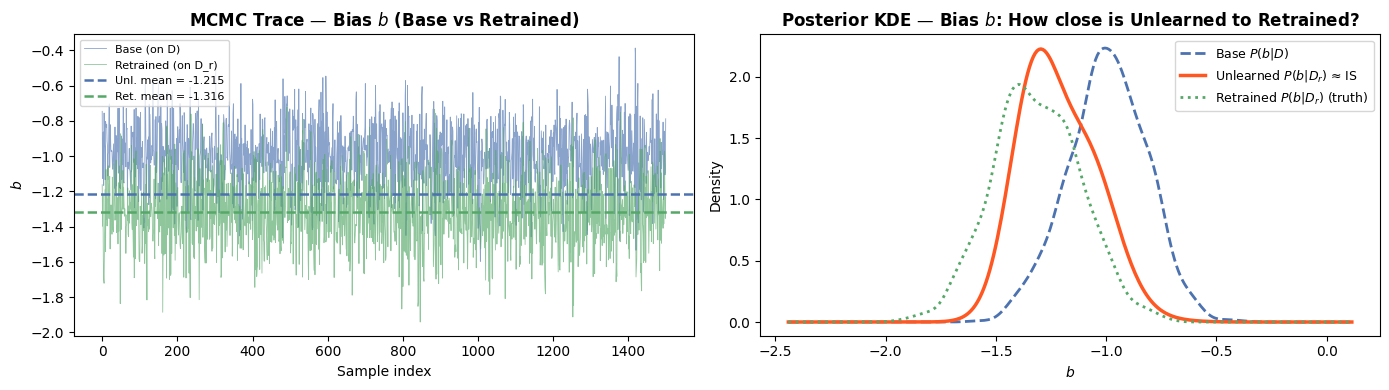

In [15]:
print("Retraining from scratch on D_r (ground truth)...")
retrained_samples = train_mcmc(X_r, y_r, num_warmup=500, num_samples=1500,
                                rng_key=random.PRNGKey(2))

b_base_np      = np.array(base_samples["b"])
b_retrained_np = np.array(retrained_samples["b"])
b_unlearned_mean = np.average(b_base_np, weights=weights_np)

print(f"\nBias b posterior summary:")
print(f"  Base      mean: {b_base_np.mean():.4f}  std: {b_base_np.std():.4f}")
print(f"  Unlearned mean: {b_unlearned_mean:.4f}  (weighted from base)")
print(f"  Retrained mean: {b_retrained_np.mean():.4f}  std: {b_retrained_np.std():.4f}")

# --- Overlay MCMC traces: Base vs Retrained ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(b_base_np,      alpha=0.65, color="#4C72B0", linewidth=0.6, label="Base (on D)")
axes[0].plot(b_retrained_np, alpha=0.65, color="#55A868", linewidth=0.6, label="Retrained (on D_r)")
axes[0].axhline(b_unlearned_mean,        color="#4C72B0", linestyle="--",
                linewidth=1.8, label=f"Unl. mean = {b_unlearned_mean:.3f}")
axes[0].axhline(b_retrained_np.mean(),   color="#55A868", linestyle="--",
                linewidth=1.8, label=f"Ret. mean = {b_retrained_np.mean():.3f}")
axes[0].set_title("MCMC Trace — Bias $b$ (Base vs Retrained)", fontweight="bold")
axes[0].set_xlabel("Sample index")
axes[0].set_ylabel("$b$")
axes[0].legend(fontsize=8)

# KDE overlay for b
z_range = np.linspace(
    min(b_base_np.min(), b_retrained_np.min()) - 0.5,
    max(b_base_np.max(), b_retrained_np.max()) + 0.5, 300)
kde_base_b = scipy.stats.gaussian_kde(b_base_np)
kde_ret_b  = scipy.stats.gaussian_kde(b_retrained_np)
kde_unl_b  = scipy.stats.gaussian_kde(b_base_np, weights=weights_np)

axes[1].plot(z_range, kde_base_b(z_range), "--", color="#4C72B0", linewidth=2,
             label="Base $P(b|D)$")
axes[1].plot(z_range, kde_unl_b(z_range),  "-",  color="#FF5722", linewidth=2.5,
             label="Unlearned $P(b|D_r)$ ≈ IS")
axes[1].plot(z_range, kde_ret_b(z_range),  ":",  color="#55A868", linewidth=2,
             label="Retrained $P(b|D_r)$ (truth)")
axes[1].set_title("Posterior KDE — Bias $b$: How close is Unlearned to Retrained?",
                  fontweight="bold")
axes[1].set_xlabel("$b$")
axes[1].set_ylabel("Density")
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

## Section 8 — Predictive Accuracy Comparison

We evaluate all three models on the held-out test set (200 samples) using:

$$\hat{y} = \mathbb{1}\!\left[\frac{1}{N}\sum_{i=1}^N \sigma(\theta_i^\top x^*) > 0.5\right] \quad \text{(Base / Retrained)}$$

$$\hat{y} = \mathbb{1}\!\left[\sum_{i=1}^N \tilde{w}_i \cdot \sigma(\theta_i^\top x^*) > 0.5\right] \quad \text{(Unlearned)}$$

### Key Insight
**Accuracy alone cannot confirm unlearning.** A model can "forget" training data while keeping the same test accuracy — the test set was never exposed to $D_e$. The Wasserstein distance in Section 9 is the real verification metric.

┌──────────────────────────────────┬──────────┐
│ Model                            │ Accuracy │
├──────────────────────────────────┼──────────┤
│ Base (trained on D)              │  0.9100  │
│ Unlearned (MCU IS-weighted)      │  0.8950  │
│ Retrained (ground truth)         │  0.8850  │
└──────────────────────────────────┴──────────┘


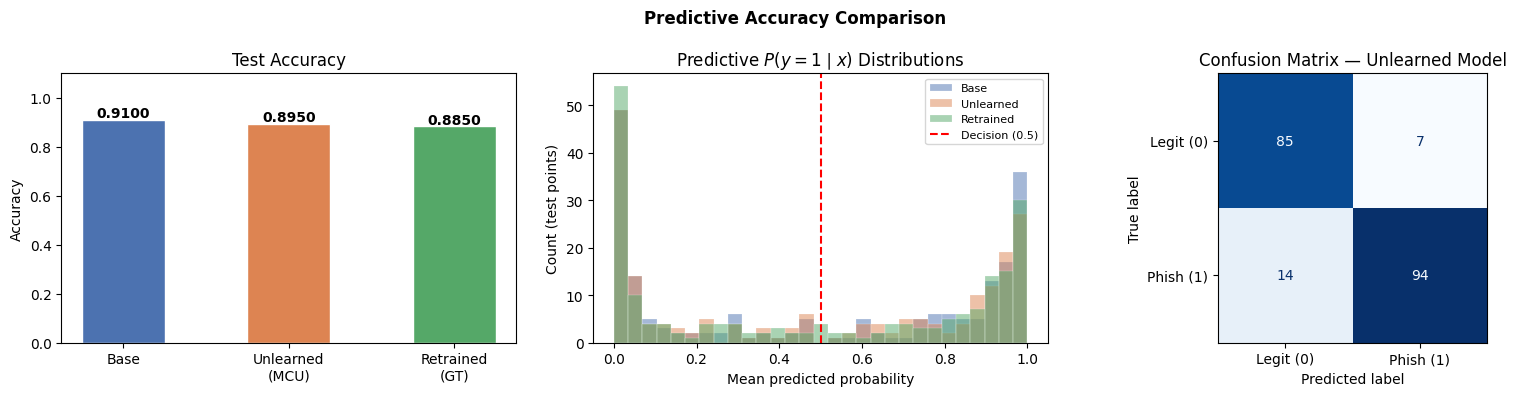

In [16]:
def predict(X, posterior_samples, weights=None):
    w = posterior_samples['w']
    b = posterior_samples['b']
    logits = jnp.dot(w, jnp.array(X, dtype=jnp.float32).T) + b[:, None]
    probs = jax.nn.sigmoid(logits)
    if weights is None:
        mean_probs = jnp.mean(probs, axis=0)
    else:
        mean_probs = jnp.sum(probs * weights[:, None], axis=0)
    return np.array((mean_probs > 0.5).astype(int)), np.array(mean_probs)

y_pred_base,      p_base = predict(X_test, base_samples)
y_pred_unlearned, p_unl  = predict(X_test, base_samples, weights=unlearning_weights)
y_pred_retrained, p_ret  = predict(X_test, retrained_samples)

acc_base      = accuracy_score(y_test, y_pred_base)
acc_unlearned = accuracy_score(y_test, y_pred_unlearned)
acc_retrained = accuracy_score(y_test, y_pred_retrained)

print("┌──────────────────────────────────┬──────────┐")
print("│ Model                            │ Accuracy │")
print("├──────────────────────────────────┼──────────┤")
print(f"│ Base (trained on D)              │  {acc_base:.4f}  │")
print(f"│ Unlearned (MCU IS-weighted)      │  {acc_unlearned:.4f}  │")
print(f"│ Retrained (ground truth)         │  {acc_retrained:.4f}  │")
print("└──────────────────────────────────┴──────────┘")

# --- Plots ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Predictive Accuracy Comparison", fontweight="bold")

# Accuracy bar
models = ["Base", "Unlearned\n(MCU)", "Retrained\n(GT)"]
accs   = [acc_base, acc_unlearned, acc_retrained]
colors = ["#4C72B0", "#DD8452", "#55A868"]
bars = axes[0].bar(models, accs, color=colors, edgecolor="white", width=0.5)
axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Test Accuracy")
for bar, acc in zip(bars, accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, acc + 0.01,
                 f"{acc:.4f}", ha="center", fontsize=10, fontweight="bold")

# P(y=1|x) histogram
bins = np.linspace(0, 1, 30)
for ax, probs, name, col in [
    (axes[1], p_base, "Base",      "#4C72B0"),
    (axes[1], p_unl,  "Unlearned", "#DD8452"),
    (axes[1], p_ret,  "Retrained", "#55A868")
]:
    ax.hist(probs, bins=bins, alpha=0.5, color=col, label=name, edgecolor="white", linewidth=0.3)
axes[1].axvline(0.5, color="red", linestyle="--", linewidth=1.5, label="Decision (0.5)")
axes[1].set_title("Predictive $P(y=1\\mid x)$ Distributions")
axes[1].set_xlabel("Mean predicted probability")
axes[1].set_ylabel("Count (test points)")
axes[1].legend(fontsize=8)

# Confusion matrix for unlearned model
cm = confusion_matrix(y_test, y_pred_unlearned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit (0)", "Phish (1)"])
disp.plot(ax=axes[2], colorbar=False, cmap="Blues")
axes[2].set_title("Confusion Matrix — Unlearned Model")

plt.tight_layout()
plt.show()

## Section 9 — Wasserstein Distance: Unlearning Fidelity

The **1-Wasserstein distance** ($W_1$) — also called the Earth Mover's Distance — measures the "work" needed to transform one distribution into another:

$$W_1(P_{\text{unlearned}},\, P_{\text{retrained}}) = \inf_{\gamma \in \Gamma(P_u, P_r)} \int_{\Theta \times \Theta} \|\theta - \theta'\| \; d\gamma(\theta, \theta')$$

For 1D empirical distributions, this simplifies to comparing sorted sample quantiles:

$$W_1 = \int_0^1 \left|F_u^{-1}(t) - F_r^{-1}(t)\right| dt$$

where $F_u^{-1}$ uses the IS weights $\tilde{w}_i$ for the unlearned model, and uniform weights for retrained.

We compute $W_1$ per parameter dimension ($w_0, \ldots, w_{14}, b$) then report the mean.

### Interpretation Guide
| $W_1$ | Quality |
|---|---|
| $\approx 0$ | Perfect — distributions identical |
| $< 0.05$ | Excellent unlearning |
| $0.05 - 0.2$ | Good approximation |
| $> 0.5$ | Poor — $D_e$ influence still present |

Average Wasserstein Distance (Unlearned vs Retrained): 0.1572
Unlearning quality: Good


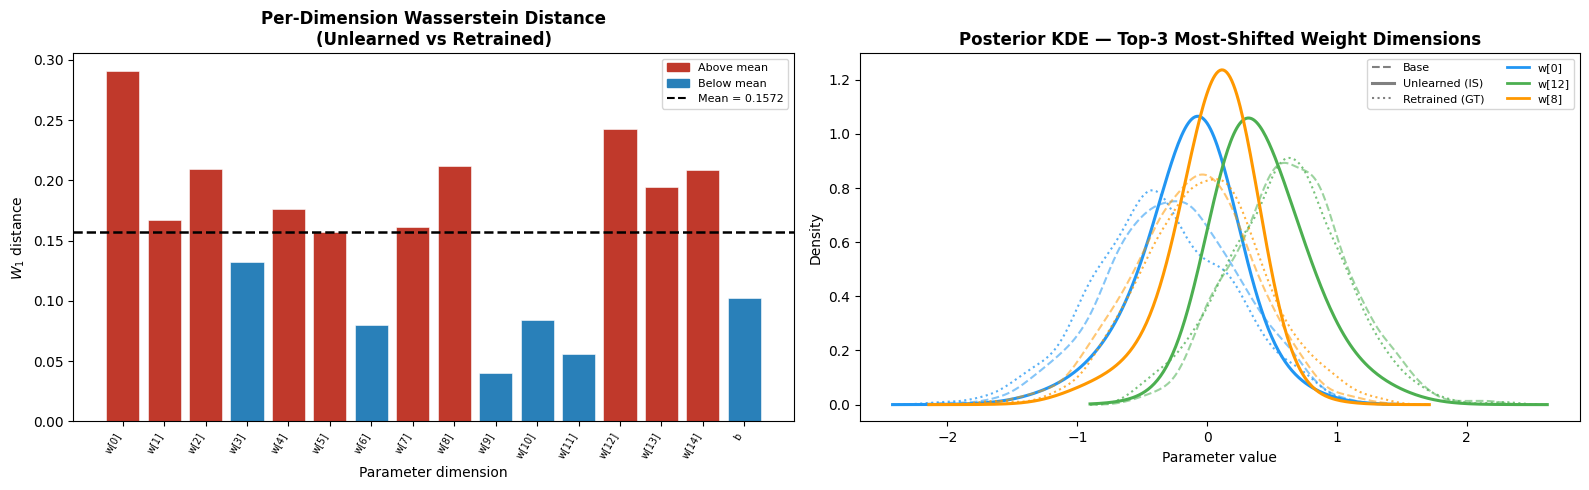

In [17]:
distances = []

for param_name in ['w', 'b']:
    s_unl = np.array(base_samples[param_name])
    s_ret = np.array(retrained_samples[param_name])
    if s_unl.ndim == 1:
        s_unl = s_unl.reshape(-1, 1)
        s_ret = s_ret.reshape(-1, 1)
    for d in range(s_unl.shape[1]):
        wd = scipy.stats.wasserstein_distance(
            u_values=s_unl[:, d],
            v_values=s_ret[:, d],
            u_weights=weights_np
        )
        distances.append(wd)

avg_wd = np.mean(distances)

print(f"Average Wasserstein Distance (Unlearned vs Retrained): {avg_wd:.4f}")
if avg_wd < 0.05:
    quality = "Excellent  ✓"
elif avg_wd < 0.2:
    quality = "Good"
elif avg_wd < 0.5:
    quality = "Moderate — consider Enlarged Candidate Set"
else:
    quality = "Poor ✗ — weight degeneracy likely"
print(f"Unlearning quality: {quality}")

# --- Per-dimension bar chart ---
n_w = np.array(base_samples["w"]).shape[1]
dim_labels = [f"w[{i}]" for i in range(n_w)] + ["b"]
bar_colors = ["#c0392b" if d > avg_wd else "#2980b9" for d in distances]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

bars = axes[0].bar(dim_labels, distances, color=bar_colors, edgecolor="white", linewidth=0.4)
axes[0].axhline(avg_wd, color="black", linestyle="--", linewidth=1.8,
                label=f"Mean $W_1$ = {avg_wd:.4f}")
axes[0].set_title("Per-Dimension Wasserstein Distance\n(Unlearned vs Retrained)",
                  fontweight="bold")
axes[0].set_xlabel("Parameter dimension")
axes[0].set_ylabel("$W_1$ distance")
axes[0].set_xticklabels(dim_labels, rotation=60, ha="right", fontsize=7)
axes[0].legend(handles=[
    Patch(color="#c0392b", label="Above mean"),
    Patch(color="#2980b9", label="Below mean"),
    Line2D([0],[0], color="black", linestyle="--", label=f"Mean = {avg_wd:.4f}")
], fontsize=8)

# Posterior KDE for top-3 most-shifted dimensions
top3_shifted = np.argsort(distances[:-1])[-3:][::-1]
palette_kde  = ["#2196F3", "#4CAF50", "#FF9800"]
w_base_np    = np.array(base_samples["w"])
w_ret_np     = np.array(retrained_samples["w"])

for rank, dim in enumerate(top3_shifted):
    col      = palette_kde[rank]
    x_b      = w_base_np[:, dim]
    x_r      = w_ret_np[:, dim]
    x_range  = np.linspace(min(x_b.min(), x_r.min()) - 0.3,
                            max(x_b.max(), x_r.max()) + 0.3, 300)
    kde_b = scipy.stats.gaussian_kde(x_b)
    kde_u = scipy.stats.gaussian_kde(x_b, weights=weights_np)
    kde_r = scipy.stats.gaussian_kde(x_r)
    lbl = f"w[{dim}]"
    axes[1].plot(x_range, kde_b(x_range), "--",  color=col, alpha=0.55, linewidth=1.5,
                 label=f"Base {lbl}")
    axes[1].plot(x_range, kde_u(x_range), "-",   color=col, alpha=1.0,  linewidth=2.2,
                 label=f"Unlearned {lbl}")
    axes[1].plot(x_range, kde_r(x_range), ":",   color=col, alpha=0.75, linewidth=1.5,
                 label=f"Retrained {lbl}")

axes[1].set_title("Posterior KDE — Top-3 Most-Shifted Weight Dimensions",
                  fontweight="bold")
axes[1].set_xlabel("Parameter value")
axes[1].set_ylabel("Density")
custom_handles = [
    Line2D([0],[0], linestyle="--", color="grey", lw=1.5, label="Base"),
    Line2D([0],[0], linestyle="-",  color="grey", lw=2.2, label="Unlearned (IS)"),
    Line2D([0],[0], linestyle=":",  color="grey", lw=1.5, label="Retrained (GT)"),
] + [Line2D([0],[0], color=palette_kde[i], lw=2, label=f"w[{top3_shifted[i]}]")
     for i in range(3)]
axes[1].legend(handles=custom_handles, fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

## Section 10 — Full Diagnostic Dashboard

The `plot_all_diagnostics()` function renders a **2×3 diagnostic dashboard** that consolidates all key views into a single exportable figure.

| Panel | What it shows | Key question answered |
|---|---|---|
| **[1] Dataset Split (PCA 2D)** | Retain (blue/orange) vs Erase (red) points | Is D_e clustered or scattered? |
| **[2] Importance Weights** | Weight histogram + ESS | Is there weight degeneracy? |
| **[3] Posterior KDE** | Base / Unlearned / Retrained marginals (top-3 dims) | Does Unlearned ≈ Retrained? |
| **[4] MCMC Trace (bias b)** | Chain trajectory + weighted mean lines | Did the posterior shift after unlearning? |
| **[5] Predictive P(y=1\|x)** | Predicted probability distributions | Did unlearning preserve utility? |
| **[6] Per-Dim W₁** | Bar chart across all 16 dimensions | Which parameters shifted most? |

The figure is saved as `mcu_diagnostics_{mode}.png`.

In [ ]:
def plot_all_diagnostics(D_r, D_e, X_test, y_test,
                         base_samples, retrained_samples,
                         unlearning_weights, distances, mode):
    weights_np = np.array(unlearning_weights)
    X_r, y_r = D_r
    X_e, y_e = D_e

    fig = plt.figure(figsize=(20, 12))
    fig.suptitle(f"MCU Diagnostic Dashboard  [{mode.upper()} DELETION MODE]",
                 fontsize=15, fontweight="bold", y=1.01)
    gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.45, wspace=0.35)

    # Panel 1: PCA dataset split
    ax1 = fig.add_subplot(gs[0, 0])
    X_all = np.vstack([X_r, X_e])
    y_all = np.concatenate([y_r, y_e])
    labs  = np.array(["Retain"]*len(X_r) + ["Erase"]*len(X_e))
    pca = PCA(n_components=2)
    X2d = pca.fit_transform(X_all)
    vr  = pca.explained_variance_ratio_
    for cls, marker, color in [(0,"o","#4C72B0"),(1,"s","#DD8452")]:
        m = y_all == cls
        ax1.scatter(X2d[m & (labs=="Retain"), 0], X2d[m & (labs=="Retain"), 1],
                    marker=marker, c=color, alpha=0.3, s=15, label=f"Retain cls={cls}")
        em = m & (labs=="Erase")
        if em.any():
            ax1.scatter(X2d[em, 0], X2d[em, 1], marker=marker, c="red",
                        edgecolors="black", linewidths=0.8, alpha=0.9, s=70,
                        label=f"Erase cls={cls}")
    ax1.set_title("[1] Dataset Split (PCA 2D)", fontweight="bold")
    ax1.set_xlabel(f"PC1 ({vr[0]*100:.1f}%)")
    ax1.set_ylabel(f"PC2 ({vr[1]*100:.1f}%)")
    ax1.legend(fontsize=7)
    ax1.text(0.02, 0.97, f"D_r={len(X_r)}  D_e={len(X_e)}",
             transform=ax1.transAxes, va="top", fontsize=8,
             bbox=dict(boxstyle="round", alpha=0.15))

    # Panel 2: Importance weights
    ax2 = fig.add_subplot(gs[0, 1])
    N   = len(weights_np)
    ess = 1.0 / np.sum(weights_np**2)
    ess_pct = ess/N*100
    ax2.hist(weights_np, bins=60, color="steelblue", edgecolor="white", linewidth=0.4)
    ax2.axvline(1/N, color="crimson", linestyle="--", lw=1.5, label=f"Uniform=1/N")
    ax2.set_title("[2] Importance Weights", fontweight="bold")
    ax2.set_xlabel("$\\tilde{w}_i$"); ax2.set_ylabel("Count")
    ax2.legend(fontsize=8)
    ax2.text(0.97, 0.93, f"ESS={ess:.0f}/{N}\n({ess_pct:.1f}%)",
             transform=ax2.transAxes, ha="right", va="top", color="darkred",
             fontweight="bold", fontsize=9, bbox=dict(boxstyle="round", alpha=0.15))
    if ess_pct < 10:
        ax2.set_facecolor("#fff0f0")
        ax2.text(0.5, 0.5, "⚠ Degeneracy", transform=ax2.transAxes,
                 fontsize=12, ha="center", color="red", alpha=0.35,
                 fontweight="bold", rotation=12)

    # Panel 3: Posterior KDE
    ax3 = fig.add_subplot(gs[0, 2])
    wb = np.array(base_samples["w"])
    wr = np.array(retrained_samples["w"])
    top3 = np.argsort(np.abs(wb.mean(axis=0)))[-3:][::-1]
    pal  = ["#2196F3","#4CAF50","#FF9800"]
    for rank, dim in enumerate(top3):
        col = pal[rank]
        xb = wb[:, dim]; xr = wr[:, dim]
        xrng = np.linspace(min(xb.min(),xr.min())-0.3, max(xb.max(),xr.max())+0.3, 300)
        ax3.plot(xrng, scipy.stats.gaussian_kde(xb)(xrng),           "--", color=col, alpha=0.6)
        ax3.plot(xrng, scipy.stats.gaussian_kde(xb,weights=weights_np)(xrng), "-", color=col, lw=2)
        ax3.plot(xrng, scipy.stats.gaussian_kde(xr)(xrng),           ":",  color=col, alpha=0.8)
    ax3.set_title("[3] Posterior Marginals (Top-3 Weights)", fontweight="bold")
    ax3.set_xlabel("Value"); ax3.set_ylabel("Density")
    ax3.legend(handles=[
        Line2D([0],[0], ls="--", color="grey", label="Base"),
        Line2D([0],[0], ls="-",  color="grey", lw=2, label="Unlearned"),
        Line2D([0],[0], ls=":",  color="grey", label="Retrained"),
    ] + [Line2D([0],[0], color=pal[i], lw=2, label=f"w[{top3[i]}]") for i in range(3)],
        fontsize=7, ncol=2)

    # Panel 4: MCMC trace for b
    ax4 = fig.add_subplot(gs[1, 0])
    bb = np.array(base_samples["b"]); br = np.array(retrained_samples["b"])
    ax4.plot(bb, alpha=0.65, color="#4C72B0", lw=0.6, label="Base")
    ax4.plot(br, alpha=0.65, color="#55A868", lw=0.6, label="Retrained")
    ax4.axhline(np.average(bb, weights=weights_np), color="#4C72B0", ls="--", lw=1.8, label="Unl. mean")
    ax4.axhline(br.mean(), color="#55A868", ls="--", lw=1.8, label="Ret. mean")
    ax4.set_title("[4] MCMC Trace — Bias $b$", fontweight="bold")
    ax4.set_xlabel("Sample index"); ax4.set_ylabel("$b$")
    ax4.legend(fontsize=8)

    # Panel 5: Predictive P(y=1|x)
    ax5 = fig.add_subplot(gs[1, 1])
    wb_np = np.array(base_samples["w"]); bb_np = np.array(base_samples["b"])
    wr_np = np.array(retrained_samples["w"]); br_np = np.array(retrained_samples["b"])
    pb = 1/(1+np.exp(-(np.dot(wb_np, X_test.T)+bb_np[:,None])))
    bins = np.linspace(0, 1, 30)
    ax5.hist(pb.mean(axis=0),                          bins=bins, alpha=0.5, color="#4C72B0", label="Base")
    ax5.hist((pb*weights_np[:,None]).sum(axis=0),       bins=bins, alpha=0.5, color="#DD8452", label="Unlearned")
    ax5.hist((1/(1+np.exp(-(np.dot(wr_np, X_test.T)+br_np[:,None])))).mean(axis=0),
             bins=bins, alpha=0.5, color="#55A868", label="Retrained")
    ax5.axvline(0.5, color="red", ls="--", lw=1.2, alpha=0.8, label="0.5")
    ax5.set_title("[5] Predictive $P(y=1\\mid x)$", fontweight="bold")
    ax5.set_xlabel("Mean probability"); ax5.set_ylabel("Count")
    ax5.legend(fontsize=8)

    # Panel 6: Per-dim Wasserstein
    ax6 = fig.add_subplot(gs[1, 2])
    n_w = np.array(base_samples["w"]).shape[1]
    dlabels = [f"w[{i}]" for i in range(n_w)] + ["b"]
    dcolors = ["#c0392b" if d > np.mean(distances) else "#2980b9" for d in distances]
    ax6.bar(dlabels, distances, color=dcolors, edgecolor="white", linewidth=0.4)
    ax6.axhline(np.mean(distances), color="black", ls="--", lw=1.8,
                label=f"Mean={np.mean(distances):.4f}")
    ax6.set_title("[6] Per-Dim Wasserstein Distance", fontweight="bold")
    ax6.set_xlabel("Dimension"); ax6.set_ylabel("$W_1$")
    ax6.set_xticklabels(dlabels, rotation=60, ha="right", fontsize=7)
    ax6.legend(handles=[Patch(color="#c0392b", label="Above mean"),
                        Patch(color="#2980b9", label="Below mean"),
                        Line2D([0],[0], color="black", ls="--",
                               label=f"Mean={np.mean(distances):.4f}")], fontsize=7)

    plt.tight_layout()
    fname = f"mcu_diagnostics_{mode}.png"
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    print(f"[Diagnostics saved → {fname}]")
    plt.show()

# Run the full dashboard
plot_all_diagnostics(D_r, D_e, X_test, y_test,
                     base_samples, retrained_samples,
                     unlearning_weights, distances, active_mode)

---

## Summary & Conclusions

### What We Did
1. **Generated** a 1000-sample binary classification dataset (phishing website analogue)
2. **Split** training data into retain set $D_r$ and erase set $D_e$ (random or cluster mode)
3. **Trained** a Bayesian Logistic Regression model via NUTS MCMC on all of $D$
4. **Applied MCU** — reweighted the posterior using importance sampling to approximate $P(\theta | D_r)$ *without* any additional sampling
5. **Verified** the result against a full retrain from scratch using Wasserstein distance

### MCU vs Full Retrain
| Criterion | MCU | Full Retrain |
|---|---|---|
| Compute cost | O(N · \|D_e\|) — cheap | O(full MCMC run) — expensive |
| Exactness | Approximation | Exact |
| Scales to large D_e | ⚠ Needs Enlarged Candidate Set | ✓ Always works |
| Scales to large D | ✓ Same cost regardless of D size | ✗ Cost grows with D |

### Key Takeaway
> A small Wasserstein distance ($W_1 < 0.05$) combined with unchanged test accuracy confirms that MCU successfully **approximates full retraining at a fraction of the cost**.

### References
- Nguyen et al., *"MCMC-Based Machine Unlearning: Faster and More General"*, ACM ASIACCS 2022  
- Hoffman & Gelman, *"The No-U-Turn Sampler"*, JMLR 2014  
- Phan et al., *NumPyro: Composable Effects for Flexible and Accelerated Probabilistic Programming*, 2019